## 第一次阶段性总结(Before RNN and NLP)
1. 薄弱的地方
    - 特征工程
    - 数学基础
2. 目前成绩: 
    - House Price 的log误差在 0.14891
3. 目标:
    - 掌握特征工程
    - 掌握MXNET的使用以及训练过程
    - 掌握梯度下降和回归算法
    - 掌握CNN
    - House Price 降到0.13 以下
4. 吃透它们的本质:
    - MXNet
    - Regression
    - CNN

### Iris 分类
1. 处理 鸢尾花数据集
2. 按60/20/20划分数据集
3. 使用逻辑回归进行分类预测
4. 调参

In [5]:
import sys
import time
import random
from matplotlib import pyplot as plt
from mxnet import nd, autograd, init
from mxnet.gluon.trainer import Trainer
from mxnet.gluon.nn import Sequential, Dense, Activation, Conv2D, MaxPool2D
from mxnet.gluon.data import DataLoader
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss

In [6]:
nd.array([1,2,3])


[1. 2. 3.]
<NDArray 3 @cpu(0)>

In [7]:
# 鸢尾花, Iris 数据集
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
label_map = dict([(ele, i) for i, ele in enumerate(labels)])


def parse_iris_data(train_rate=0.6, validate_rate=0.2):
    """
    Columns: 
        Sepal Length
        Sepal Width
        Petal length
        Petal width
        class
    return: iris_train, iris_valid, iris_test
    """
    iris_dataset = list()
    with open("./DataResources/Summary_1/iris.csv", "r") as fr:
        for row in fr.readlines():
            row = row.strip()
            if not row:
                continue
            tokens = row.split(',')
            iris_dataset.append((
                nd.array([float(num) for num in tokens[:-1]]), 
                label_map[tokens[-1]]
            ))
    random.shuffle(iris_dataset)
    size = len(iris_dataset)
    train_ind, valid_ind = int(round(size * train_rate)), int(round(size * validate_rate))
    train_set = iris_dataset[:train_ind]
    validate_set = iris_dataset[train_ind:train_ind + valid_ind]
    test_set = iris_dataset[train_ind + valid_ind:]
    return train_set, validate_set, test_set


def load_iris_data(batch_size):
    train_set, validate_set, test_set = parse_iris_data()
    return (
        DataLoader(train_set, batch_size, shuffle=True),
        DataLoader(validate_set, batch_size, shuffle=False),
        DataLoader(test_set, batch_size, shuffle=False),        
    )

In [8]:
batch_size = 15
train_iter, validate_iter, test_iter = load_iris_data(batch_size)

In [9]:
for sample_X, sample_y in train_iter:
    print(sample_X)
    print(sample_y)
    break
sample_y.sum()


[[6.1 2.8 4.  1.3]
 [5.9 3.  4.2 1.5]
 [6.1 3.  4.9 1.8]
 [4.8 3.4 1.9 0.2]
 [5.  3.4 1.5 0.2]
 [5.9 3.  5.1 1.8]
 [5.2 4.1 1.5 0.1]
 [6.4 2.8 5.6 2.1]
 [6.3 3.4 5.6 2.4]
 [7.  3.2 4.7 1.4]
 [5.2 3.5 1.5 0.2]
 [5.7 2.5 5.  2. ]
 [5.5 2.4 3.8 1.1]
 [5.  2.  3.5 1. ]
 [7.7 3.  6.1 2.3]]
<NDArray 15x4 @cpu(0)>

[1 1 2 0 0 2 0 2 2 1 0 2 1 1 2]
<NDArray 15 @cpu(0)>



[17]
<NDArray 1 @cpu(0)>

In [10]:
def sum_accuracy(y_hat, y):
    """
    :param y_hat, prediction
    :param y, label
    :return int
    """
    y_hat = y_hat.argmax(axis=1).astype('int')
    # print(y_hat, y)
    return (y_hat == y).sum().asscalar() 


def evaluate_accuracy(data_iter, net):
    correct_count, total_count = 0, 0
    for X, y in data_iter:
        # X, y = X, y.astype('float32')
        # 因为sum() 是一个 1x1的vector
        correct_count += sum_accuracy(net(X), y)
        total_count += y.size
    return correct_count / total_count


def train_lr(net, train_iter, test_iter, batch_size, trainer, num_epochs):
    loss = SoftmaxCrossEntropyLoss()
    for epoch in range(num_epochs):
        epoch_time = time.time()
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            train_l_sum += l.asscalar()
            train_acc_sum += sum_accuracy(y_hat, y)
            n += y.size
            # print(net[0].weight.data())
            # print(net[0].bias.data())
        test_acc = evaluate_accuracy(test_iter, net)
        print('Epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec' % (
            epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc, time.time() - epoch_time))

In [11]:
lr_net = Sequential()
lr_net.add(
    Dense(10),
    Activation('relu'),
    Dense(len(label_map)),
    # Activation('sigmoid')
)

In [25]:
lr_net.collect_params()

sequential0_ (
  Parameter dense0_weight (shape=(10, 4), dtype=float32)
  Parameter dense0_bias (shape=(10,), dtype=float32)
  Parameter dense1_weight (shape=(3, 10), dtype=float32)
  Parameter dense1_bias (shape=(3,), dtype=float32)
)

In [12]:
lr, num_epochs = 0.01, 500
batch_size = 30
lr_net.initialize(force_reinit=True)
sgd_trainer = Trainer(lr_net.collect_params(), 'sgd', {'learning_rate': lr})
train_lr(lr_net, train_iter, validate_iter, batch_size, sgd_trainer, num_epochs)

Epoch 1, loss 1.1094, train acc 0.000, test acc 0.000, time 0.0 sec
Epoch 2, loss 1.1083, train acc 0.189, test acc 0.233, time 0.0 sec
Epoch 3, loss 1.1070, train acc 0.333, test acc 0.333, time 0.0 sec
Epoch 4, loss 1.1060, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 5, loss 1.1051, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 6, loss 1.1041, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 7, loss 1.1034, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 8, loss 1.1027, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 9, loss 1.1019, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 10, loss 1.1012, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 11, loss 1.1004, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 12, loss 1.0999, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 13, loss 1.0994, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 14, loss 1.0987, train acc 0.356, test acc 0.333, time 0.0 sec
Epoch 15, loss 1.0979, train acc 0.356, tes

Epoch 126, loss 0.7994, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 127, loss 0.7948, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 128, loss 0.7905, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 129, loss 0.7861, train acc 0.644, test acc 0.667, time 0.1 sec
Epoch 130, loss 0.7822, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 131, loss 0.7785, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 132, loss 0.7729, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 133, loss 0.7687, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 134, loss 0.7644, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 135, loss 0.7600, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 136, loss 0.7552, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 137, loss 0.7513, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 138, loss 0.7466, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 139, loss 0.7421, train acc 0.644, test acc 0.667, time 0.0 sec
Epoch 140, loss 0.73

Epoch 245, loss 0.4188, train acc 0.967, test acc 0.900, time 0.0 sec
Epoch 246, loss 0.4193, train acc 0.956, test acc 0.900, time 0.0 sec
Epoch 247, loss 0.4154, train acc 0.978, test acc 0.900, time 0.0 sec
Epoch 248, loss 0.4141, train acc 0.956, test acc 0.900, time 0.0 sec
Epoch 249, loss 0.4127, train acc 0.956, test acc 0.900, time 0.0 sec
Epoch 250, loss 0.4115, train acc 0.933, test acc 0.900, time 0.0 sec
Epoch 251, loss 0.4095, train acc 0.944, test acc 0.933, time 0.0 sec
Epoch 252, loss 0.4083, train acc 0.933, test acc 0.933, time 0.0 sec
Epoch 253, loss 0.4054, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 254, loss 0.4047, train acc 0.978, test acc 0.933, time 0.0 sec
Epoch 255, loss 0.4032, train acc 0.978, test acc 0.933, time 0.0 sec
Epoch 256, loss 0.4026, train acc 0.989, test acc 0.900, time 0.0 sec
Epoch 257, loss 0.4012, train acc 0.944, test acc 0.933, time 0.0 sec
Epoch 258, loss 0.3984, train acc 0.967, test acc 0.933, time 0.0 sec
Epoch 259, loss 0.39

Epoch 367, loss 0.2571, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 368, loss 0.2557, train acc 0.978, test acc 0.933, time 0.0 sec
Epoch 369, loss 0.2541, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 370, loss 0.2535, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 371, loss 0.2539, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 372, loss 0.2520, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 373, loss 0.2496, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 374, loss 0.2480, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 375, loss 0.2475, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 376, loss 0.2460, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 377, loss 0.2454, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 378, loss 0.2462, train acc 0.978, test acc 0.933, time 0.0 sec
Epoch 379, loss 0.2438, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 380, loss 0.2419, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 381, loss 0.24

Epoch 489, loss 0.1634, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 490, loss 0.1635, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 491, loss 0.1636, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 492, loss 0.1634, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 493, loss 0.1623, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 494, loss 0.1623, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 495, loss 0.1634, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 496, loss 0.1608, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 497, loss 0.1617, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 498, loss 0.1597, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 499, loss 0.1590, train acc 0.989, test acc 0.933, time 0.0 sec
Epoch 500, loss 0.1586, train acc 0.989, test acc 0.933, time 0.0 sec


In [13]:
lr_net[0].weight.data()


[[-0.01271671  0.01269481 -0.00730836  0.03197381]
 [ 0.1792873   0.1668134  -0.08041652 -0.04327776]
 [ 0.36498207  0.4347408  -0.32291788 -0.24100651]
 [-0.03426675 -0.04169572  0.09146401 -0.02635823]
 [ 0.04996303 -0.23405564  0.3902634   0.18659246]
 [ 0.8295938   0.63149947 -0.41004917 -0.4238149 ]
 [-0.08855809 -0.37528387  1.0866351   0.6572686 ]
 [-0.06005495 -0.02276454 -0.0578019   0.02074406]
 [-0.06716943 -0.01844618  0.04656678  0.06400172]
 [-0.03536167 -0.3693265   0.92040545  0.55381024]]
<NDArray 10x4 @cpu(0)>

In [14]:
sample_X[0], sample_y[0]

(
 [6.1 2.8 4.  1.3]
 <NDArray 4 @cpu(0)>, 
 [1]
 <NDArray 1 @cpu(0)>)

In [15]:
lr_net(sample_X), sample_y

(
 [[-1.550872    2.1073878  -0.28410688]
  [-2.214271    2.0507545   0.45316824]
  [-4.1367297   2.0272052   2.4657376 ]
  [ 4.770071    2.1021593  -6.812176  ]
  [ 5.7602754   2.1902764  -7.9144583 ]
  [-4.77082     1.9538867   3.1891685 ]
  [ 6.4218154   2.4171035  -8.798744  ]
  [-6.2519956   1.9954631   4.684999  ]
  [-5.964439    2.0472405   4.3396373 ]
  [-2.02639     2.3861532  -0.04088274]
  [ 5.980361    2.269035   -8.212486  ]
  [-5.703463    1.7872314   4.3026204 ]
  [-1.8363768   1.8914683   0.20554075]
  [-1.9575537   1.7015052   0.50111544]
  [-6.3549895   2.358061    4.465678  ]]
 <NDArray 15x3 @cpu(0)>, 
 [1 1 2 0 0 2 0 2 2 1 0 2 1 1 2]
 <NDArray 15 @cpu(0)>)

In [47]:
image_shape = (28, 28)

def parse_csv(filename):
    dataset = list()
    print("Read {} START.".format(filename))
    with open(filename, 'r') as fr: 
        for row in fr.readlines()[1:]:
            row = row.strip()
            if not row:
                continue
            tokens = [int(num) for num in row.split(',')]
            if len(tokens) == 784:  # 没有label
                dataset.append(tokens)
            else:
                dataset.append((nd.array(tokens[1:]).reshape((1, 28, 28)), tokens[0]))  # .reshape(image_shape)
    print("Read {} DONE.".format(filename))
    return dataset


def load_mnist_train_set(batch_size, rate=0.6):
    print("load_mnist_train_set() START")
    dataset = parse_csv('./DataResources/Summary_1/mnist_train.csv')
    split_ind = int(len(dataset) * rate)
    train_set = dataset[:split_ind]
    test_set = dataset[split_ind:]
    print("Train Size: {}, Test Size: {}".format(split_ind, len(dataset) - split_ind))
    return (
        DataLoader(train_set, batch_size, shuffle=True),
        DataLoader(test_set, batch_size, shuffle=False),
    )


def load_mnist_test_set():
    print("load_mnist_test_set() START")
    dataset = parse_csv('./DataResources/Summary_1/mnist_test.csv')
    print("load_mnist_test_set() DONE")
    return nd.array(dataset).reshape((len(dataset), 1, 28, 28))

In [17]:
test_reshape = [range(784), range(784), range(784)]
nd.array(test_reshape).reshape((3, 28, 28))


[[[  0.   1.   2. ...  25.  26.  27.]
  [ 28.  29.  30. ...  53.  54.  55.]
  [ 56.  57.  58. ...  81.  82.  83.]
  ...
  [700. 701. 702. ... 725. 726. 727.]
  [728. 729. 730. ... 753. 754. 755.]
  [756. 757. 758. ... 781. 782. 783.]]

 [[  0.   1.   2. ...  25.  26.  27.]
  [ 28.  29.  30. ...  53.  54.  55.]
  [ 56.  57.  58. ...  81.  82.  83.]
  ...
  [700. 701. 702. ... 725. 726. 727.]
  [728. 729. 730. ... 753. 754. 755.]
  [756. 757. 758. ... 781. 782. 783.]]

 [[  0.   1.   2. ...  25.  26.  27.]
  [ 28.  29.  30. ...  53.  54.  55.]
  [ 56.  57.  58. ...  81.  82.  83.]
  ...
  [700. 701. 702. ... 725. 726. 727.]
  [728. 729. 730. ... 753. 754. 755.]
  [756. 757. 758. ... 781. 782. 783.]]]
<NDArray 3x28x28 @cpu(0)>

In [36]:
batch_size = 128
mnist_train_iter, mnist_test_iter = load_mnist_train_set(batch_size)

load_mnist_train_set() START
Read ./DataResources/Summary_1/mnist_train.csv START.
Read ./DataResources/Summary_1/mnist_train.csv DONE.
Train Size: 25200, Test Size: 16800


In [37]:
for sample_Image, sample_Num in mnist_train_iter:
    print(sample_Image)
    print(sample_Num)
    break


[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0.

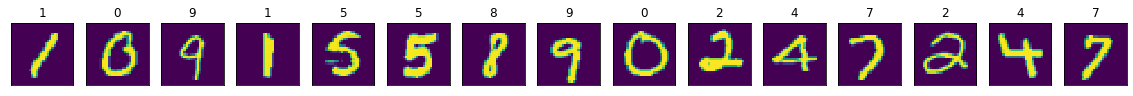

In [38]:
# Visulization
show_num = 15
i = 0
_, figs = plt.subplots(1, show_num, figsize=(20, 20))
for image_pixel, image_label in zip(sample_Image, sample_Num):
    # 不会自动换行
    if i >= show_num:
        break
    f = figs[i]
    f.imshow(image_pixel.reshape(image_shape).asnumpy())
    f.set_title(str(image_label.asscalar()))
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    i += 1

In [39]:
# 定义LeNet卷积网络
lenet = Sequential()
lenet.add(
    Conv2D(channels=6, kernel_size=5, activation='sigmoid'),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
    MaxPool2D(pool_size=2, strides=2),
    # Dense会默认将(批量大小, 通道, 高, 宽)形状的输入转换成
    # (批量大小, 通道 * 高 * 宽)形状的输入
    Dense(120, activation='sigmoid'),
    Dense(84, activation='sigmoid'),
    Dense(10)
)

In [40]:
# 训练LeNet
def train_cnn(net, train_iter, test_iter, batch_size, trainer, num_epochs):
    loss = SoftmaxCrossEntropyLoss()
    for epoch in range(num_epochs):
        epoch_time = time.time()
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            train_l_sum += l.asscalar()
            train_acc_sum += sum_accuracy(y_hat, y)
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec' % (
            epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc, time.time() - epoch_time))

In [41]:
lenet.collect_params()

sequential3_ (
  Parameter conv4_weight (shape=(6, 0, 5, 5), dtype=<class 'numpy.float32'>)
  Parameter conv4_bias (shape=(6,), dtype=<class 'numpy.float32'>)
  Parameter conv5_weight (shape=(16, 0, 5, 5), dtype=<class 'numpy.float32'>)
  Parameter conv5_bias (shape=(16,), dtype=<class 'numpy.float32'>)
  Parameter dense8_weight (shape=(120, 0), dtype=float32)
  Parameter dense8_bias (shape=(120,), dtype=float32)
  Parameter dense9_weight (shape=(84, 0), dtype=float32)
  Parameter dense9_bias (shape=(84,), dtype=float32)
  Parameter dense10_weight (shape=(10, 0), dtype=float32)
  Parameter dense10_bias (shape=(10,), dtype=float32)
)

In [58]:
lr, num_epochs = 0.9, 200
lenet.initialize(force_reinit=True, init=init.Xavier())
trainer = Trainer(lenet.collect_params(), 'sgd', {'learning_rate': lr})
train_cnn(lenet, mnist_train_iter, mnist_test_iter, batch_size, trainer, num_epochs)

KeyboardInterrupt: 

In [49]:
submission = load_mnist_test_set()

load_mnist_test_set() START
Read ./DataResources/Summary_1/mnist_test.csv START.
Read ./DataResources/Summary_1/mnist_test.csv DONE.
load_mnist_test_set() DONE


In [50]:
submission = lenet(submission)

In [56]:
def save_submission():
    result = submission.argmax(axis=1).asnumpy()
    with open("lenet_985.csv", "w") as fw: 
        fw.write('ImageId,Label\n')
        for i, num in enumerate(result):
            fw.write("{},{}\n".format(i+1, int(num)))

In [57]:
save_submission()

### 结果 : 0.98442